# Example 02 - Sig53 Classifier
This notebook walks through a simple example of how to use the clean Sig53 dataset, load a pre-trained supported model, and evaluate the trained network's performance. Note that the experiment and the results herein are not to be interpreted with any significant value but rather serve simply as a practical example of how the `torchsig` dataset and tools can be used and integrated within a typical [PyTorch](https://pytorch.org/) and/or [PyTorch Lightning](https://www.pytorchlightning.ai/) workflow.

----

## Import Libraries
First, import all the necessary public libraries as well as a few classes from the `torchsig` toolkit.

In [1]:
from torchsig.transforms.target_transforms import DescToClassIndex
from torchsig.utils.writer import DatasetCreator
from torchsig.transforms.transforms import (
    RandomPhaseShift,
    Normalize,
    ComplexTo2D,
    Compose,
)
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import LightningModule, Trainer
from sklearn.metrics import classification_report
from torchsig.utils.cm_plotter import plot_confusion_matrix
from torchsig.datasets.sig53 import Sig53
from torchsig.datasets.modulations import ModulationsDataset
from torchsig.datasets.datamodules import Sig53DataModule
from torch.nn import CrossEntropyLoss
from torchsig.datasets import conf
from torch import optim
import pytorch_lightning as pl
from tqdm import tqdm
import torch.nn.functional as F
from torchmetrics import Accuracy
import numpy as np
import torch

from torchsig.models import EfficientNet1d

----
### Instantiate Sig53 Dataset
Here, we instantiate the Sig53 clean training dataset and the Sig53 clean validation dataset. We demonstrate how to compose multiple TorchSig transforms together, using a data impairment with a random phase shift that uniformly samples a phase offset between -1 pi and +1 pi. The next transform normalizes the complex tensor, and the final transform converts the complex data to a real-valued tensor with the real and imaginary parts as two channels. We additionally provide a target transform that maps the `SignalMetadata` objects, that are part of `SignalData` objects, to a desired format for the model we will train. In this case, we use the `DescToClassIndex` target transform to map class names to their indices within an ordered class list. Finally, we sample from our datasets and print details in order to confirm functionality.

For more details on the Sig53 dataset instantiations, please see `00_example_sig53_dataset.ipynb`.

In [2]:
# Specify Sig53 Options
root = "./"
impaired = False
class_list = list(Sig53._idx_to_name_dict.values())
batch_size = 64
num_workers = 4

transform = Compose(
    [
        RandomPhaseShift(phase_offset=(-1, 1)),
        Normalize(norm=np.inf),
        ComplexTo2D(),
    ]
)
target_transform = DescToClassIndex(class_list=class_list)

datamodule = Sig53DataModule(
    root=root,
    impaired=False,
    transform=transform,
    target_transform=target_transform,
    batch_size=batch_size,
    num_workers=num_workers
)
datamodule.prepare_data()
datamodule.setup("fit")

# Retrieve a sample and print out information to verify
idx = np.random.randint(len(datamodule.train))
data, label = datamodule.train[idx]
print("Dataset length: {}".format(len(datamodule.train)))
print("Data shape: {}".format(data.shape))
print("Label Index: {}".format(label))
print("Label Class: {}".format(Sig53.convert_idx_to_name(label)))

Using Sig53CleanTrainQAConfig for train.
Using Sig53CleanValQAConfig for val.


84it [00:46,  1.82it/s]                        


9it [00:05,  1.65it/s]                       

Dataset length: 10600
Data shape: (2, 4096)
Label Index: 10
Label Class: 16ask


----
## Instantiate Supported TorchSig Model
Below, we create a 1d EfficientNet-B0 model, and then conform it to a PyTorch LightningModule for training.

In [3]:
model = EfficientNet1d(2,53)

In [4]:
class ExampleClassifier(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.mdl = model
        self.loss_fn = CrossEntropyLoss()
        self.acc = Accuracy(task="multiclass",num_classes=53,top_k=5)
    def forward(self,batch):
        return self.mdl(batch[0].float()).argmax(-1),batch[1]

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())
    
    def training_step(self, batch):
        x, y = (batch[0].float(),batch[1])
        y_hat = self.mdl(x)
        return self.loss_fn(y_hat, y)

    def validation_step(self, batch):
        x, y = (batch[0].float(),batch[1])
        y_hat = self.mdl(x)
        loss = self.loss_fn(y_hat, y)
        self.acc(y_hat,y)
        results = {"val/loss": loss, "val/acc": self.acc}
        self.log_dict(results, prog_bar=True)
        return results
example_model = ExampleClassifier(model)

----
## Train the Model
To train the model, we first create a `ModelCheckpoint` to monitor the validation loss over time and save the best model as we go. The network is then instantiated and passed into a `Trainer` to kick off training.

In [5]:
trainer = pl.Trainer(
    max_epochs=25,
)
trainer.fit(example_model, datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precisio

Dataset already exists in .//sig53_clean_train. Not regenerating
Dataset already exists in .//sig53_clean_val. Not regenerating


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


In [6]:
preds = trainer.predict(example_model,datamodule.val_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Dataset already exists in .//sig53_clean_train. Not regenerating
Dataset already exists in .//sig53_clean_val. Not regenerating


Predicting: |          | 0/? [00:00<?, ?it/s]

In [7]:
y_hat = torch.cat([p[0] for p in preds])
y = torch.cat([p[1] for p in preds])

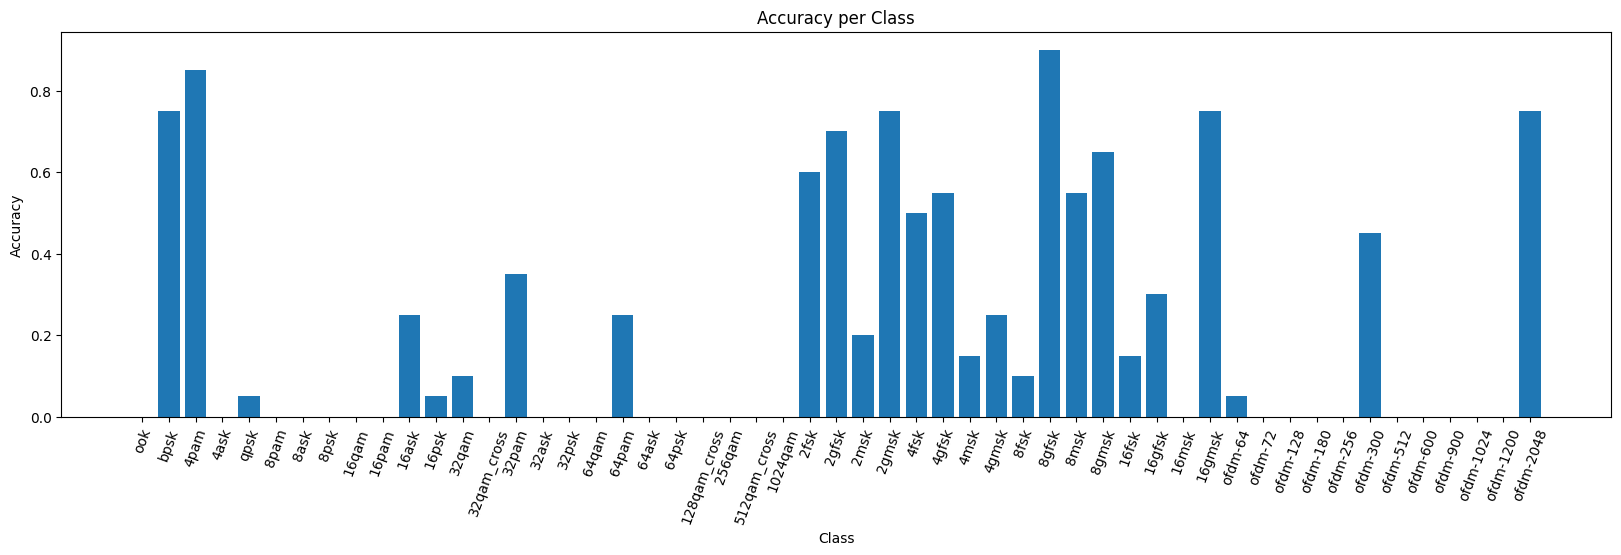

In [8]:
import numpy as np
import matplotlib.pyplot as plt

accuracy_per_class = []
for cls in range(53):
    # Select predictions and labels for the current class
    cls_predictions = y_hat[y == cls]
    cls_labels = y[y == cls]
    
    # Calculate accuracy
    accuracy = torch.mean((cls_predictions == cls_labels).float())
    accuracy_per_class.append(accuracy)

# Plot the accuracy per class
plt.figure(figsize=(20, 5))
plt.bar(class_list, accuracy_per_class)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Accuracy per Class')
plt.xticks(class_list,rotation=70)
plt.show()
